In [1]:
import torch
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader
import sys
import geotorch
from itertools import cycle
from tqdm.auto import trange
from tqdm.notebook import tqdm

sys.path.append('../')
from matplotlib import cm
import matplotlib.pyplot as plt

from utils import plot, s3w, vmf, misc
from utils.nf import normalizing_flows
from methods import s3wd, sswd

from experiments import gf_particles, gd_sphere

from scipy.stats import gaussian_kde

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [3]:
mu_target = [0,0,1]
mu_target = mu_target / np.linalg.norm(mu_target)

kappa_target = 10

X_target = torch.tensor(vmf.rand_vmf(mu_target, kappa=kappa_target, N=30000), dtype=torch.float)


## Gradient Flow on Particles

In [19]:
X0 = torch.randn((300, 3), device=device)
X0 = F.normalize(X0, p=2, dim=-1)
X0.requires_grad_(True)
L = [X0.clone()]
L_loss = []

In [16]:
d_func = s3wd.ri_s3wd 
d_args = {'p': 2, 'n_projs': 100, 'device': device, 'n_rotations': 1000}#, 'pool_size':5000}

L, L_loss = gf_particles.run_exp(X_target, X0, d_func , d_args, device, n_steps=201, lr=0.09, batch_size=300)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [01:10<00:00,  2.85it/s, Loss = 0.333]


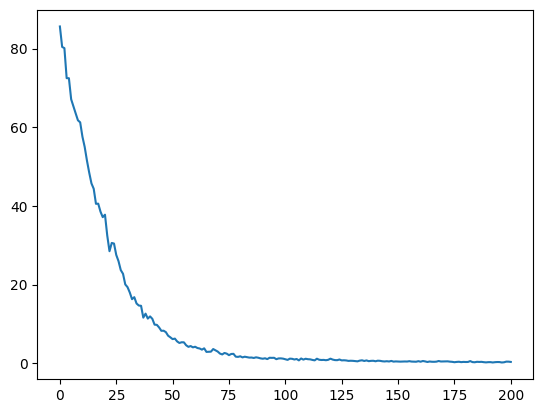

In [18]:
plt.plot(L_loss)

In [20]:
d_func = s3wd.ari_s3wd 
d_args = {'p': 2, 'n_projs': 100, 'device': device, 'n_rotations': 1000, 'pool_size':5000}

L1, L_loss1 = gf_particles.run_exp(X_target, X0, d_func , d_args, device, n_steps=201, lr=0.09, batch_size=300)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:09<00:00, 22.23it/s, Loss = 0.156]


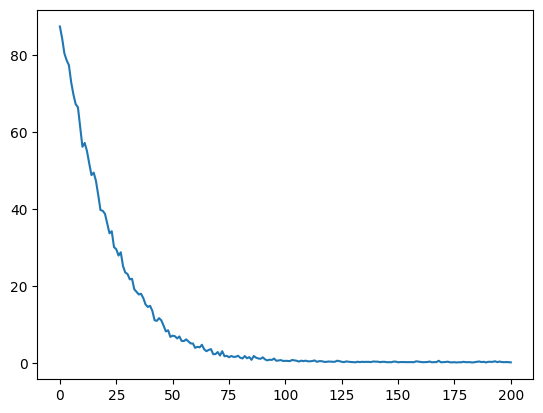

In [21]:
plt.plot(L_loss1)

In [23]:
def run_exp_(X_target, X0, d_func, d_args, device, n_steps=2000, lr=0.1, batch_size=500):
    loader = DataLoader(X_target, batch_size=batch_size, shuffle=True)
    dataiter = cycle(loader)
    scheduler = s3w.LinearRS(1,1000, n_steps)
    X0 = X0.to(device)
    X0.requires_grad_(True)

    L = [X0.clone()]
    L_loss = []

    pbar = trange(n_steps)

    for k in pbar:
        nR=scheduler.get()
        X_batch = next(dataiter).type(torch.float).to(device)

        distance = d_func(X_batch, X0, n_rotations=nR, **d_args)
        grad_x0 = torch.autograd.grad(distance, X0)[0]

        X0 = X0 - lr * grad_x0
        X0 = F.normalize(X0, p=2, dim=1)
        scheduler.step()
        if torch.any(torch.isnan(grad_x0)):
            pass

        L_loss.append(distance.item())
        L.append(X0.clone().detach())
        pbar.set_postfix_str(f"Loss = {distance.item():.3f}")

    return L, L_loss

In [25]:
d_func = s3wd.ari_s3wd 
d_args = {'p': 2, 'n_projs': 100, 'device': device, 'pool_size':5000}

L2, L_loss2 = run_exp_(X_target, X0, d_func , d_args, device, n_steps=201, lr=0.09, batch_size=300)

  0%|          | 0/201 [00:00<?, ?it/s]

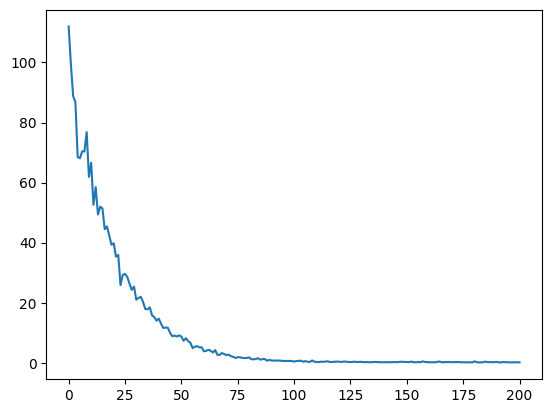

In [26]:
plt.plot(L_loss2)

In [28]:
d_func = s3wd.ri_s3wd 
d_args = {'p': 2, 'n_projs': 100, 'device': device}

L3, L_loss3 = run_exp_(X_target, X0, d_func , d_args, device, n_steps=201, lr=0.09, batch_size=300)

  0%|          | 0/201 [00:00<?, ?it/s]

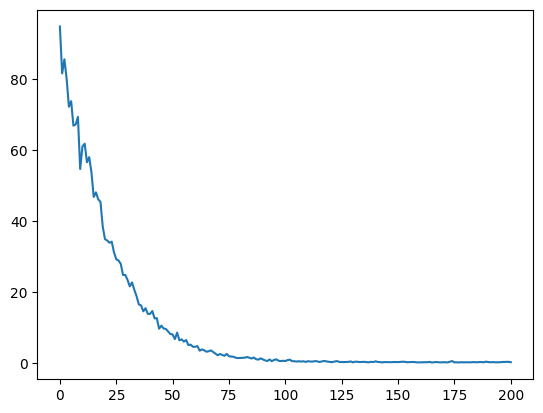

In [29]:
plt.plot(L_loss3)